In [1]:
import tensorflow          as tf
import tensorflow_datasets as tfds
import matplotlib.pyplot   as plt
import numpy               as np
import seaborn             as sns

from PIL                import Image
from google.colab       import output

from tensorflow         import keras
from keras.layers       import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D, Conv2DTranspose, Flatten, Lambda, Reshape, Cropping2D, BatchNormalization
from keras.models       import Model
from keras.applications import VGG16

from keras import backend as K

from keras.applications.vgg16 import preprocess_input

### Data preprocessing

In [2]:
def process_img(img, label):
    return decode_img(img), label

def decode_img(image):
    image = tf.image.encode_jpeg(image)
    image = tf.image.decode_jpeg(image, channels = 3)
    image = tf.image.resize(image, [HEIGHT, WIDTH])
    return image

def normalize_img(image, label):
    return tf.cast(image, tf.float32) / 255., label

### Assignment 1: Traditional Autoencoder

- Install tensorflow-datasets 
- import the colorectal_histology dataset
       images = tfds.load(name='colorectal_histology',split='train',as_supervised=True)
       images = images.batch(16)
       images = images.map(lambda img,lab: (tf.image.convert_image_dtype(img, dtype=tf.float32),lab))
       images = images.map(lambda img,lab: (img,img))
- Build an autoencoder
- Data is 150x150, use tf.keras.layers.experimental.preprocessing.Resizing to resize
- Remember how to build an image decoder from Lab 7
- Use MSE as loss
- Train the autoencoder

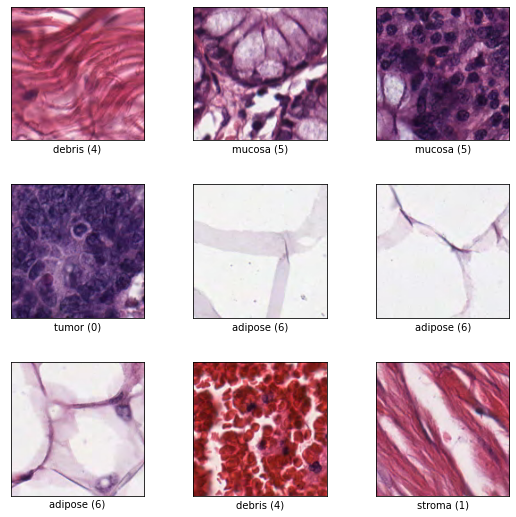

In [ ]:
images, info = tfds.load(name='colorectal_histology', split='train', as_supervised=True, with_info=True)
output.clear()

fig = tfds.show_examples(images, info)

HEIGHT = 28
WIDTH  = 28

images = images.map(process_img)
images = images.map(normalize_img)

images = images.batch(16)
images = images.map(lambda img, lab: (tf.image.convert_image_dtype(img, dtype=tf.float32), lab))
images = images.map(lambda img, lab: (img, img))

In [ ]:
input_img = (HEIGHT, WIDTH, 3)

autoencoder = Autoencoder(input_img)
autoencoder.compile(optimizer = "adam", loss = tf.keras.losses.MeanSquaredError())

autoencoder.fit(images,
                epochs=100,
                batch_size=16,
                shuffle=True)

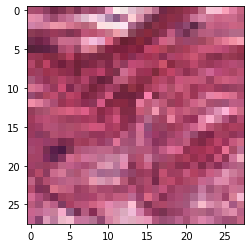

In [17]:
plt.imshow(
    tf.cast(next(iter(images.take(1))), tf.dtypes.float32)[0][0]
)

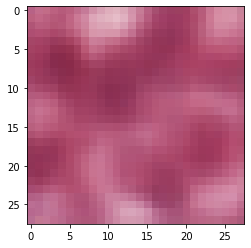

In [18]:
plt.imshow(
  autoencoder(
    tf.cast(next(iter(images.take(1))), tf.dtypes.float32)[0]
  )[0]
)

### Assignment 2: Autoencoder with perceptual loss

- Instead of using just MSE, initialize a VGG16 model pretrained on imagenet using
       tf.keras.applications.VGG16
- Optimise the sum of the previous loss and a small contribution (0.1) from the MSE in the feature space of VGG16 as the new loss (tf.keras.applications.vgg16.preprocess_input requires data in the [0,255] range)
- Compare the results

In [90]:
images, info = tfds.load(name='colorectal_histology', split='train', as_supervised=True, with_info=True)
output.clear()

HEIGHT = 148
WIDTH  = 148

images = images.map(process_img)
images = images.map(normalize_img)

images = images.batch(16)
images = images.map(lambda img, lab: (tf.image.convert_image_dtype(img, dtype=tf.float32), lab))
images = images.map(lambda img, lab: (img, img))

In [ ]:
input_img = (HEIGHT,WIDTH,3)
EPOCHS = 50

autoencoder = PLAE(input_img)
autoencoder.compile(optimizer = "adam")

autoencoder.train(images, EPOCHS)

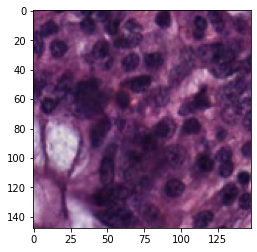

In [137]:
plt.imshow(tf.cast(next(iter(images.take(1))), tf.dtypes.float32)[0][2])

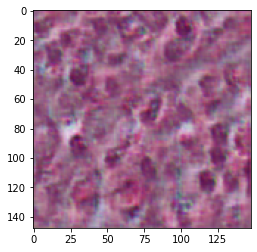

In [136]:
plt.imshow(autoencoder(tf.cast(next(iter(images.take(1))), tf.dtypes.float32)[0])[2])

### Assignment 3: Variational Autoencoder
- Use 2 fully connected layers for the latent space, one for the mean and one for the variance
- Use the reparametrization trick to sample from the distribution
- Feed the sampled vector to the decoder
- loss = reconstruction loss + β KLD (formula in slide 7)
- What happens if β is too high?

In [7]:
images, info = tfds.load(name='colorectal_histology', split='train', as_supervised=True, with_info=True)
output.clear()

HEIGHT     = 28
WIDTH      = 28
input_img  = (HEIGHT, WIDTH, 3)
latent_dim = 2

images = images.map(process_img)
images = images.map(normalize_img)
images = images.map(lambda img, lab: (tf.image.convert_image_dtype(img, dtype=tf.float32), lab))

x_train = []

for el in tfds.as_numpy(images):
  x_train.append(el[0])

x_train = np.asarray(x_train).astype(np.float32)
x_train = K.constant(x_train, name = None)

x_train.shape

TensorShape([5000, 28, 28, 3])

In [8]:
tf.compat.v1.disable_eager_execution()

def compute_latent(x):
    mu, sigma = x
    batch = K.shape(mu)[0]
    dim = K.int_shape(mu)[1]
    eps = K.random_normal(shape=(batch,dim))
    return mu + K.exp(sigma/2)*eps

# The loss function for VAE
def kl_reconstruction_loss(true, pred):
    # Reconstruction loss (binary crossentropy)
    reconstruction_loss = tf.keras.losses.binary_crossentropy(K.flatten(true), K.flatten(pred)) * WIDTH * HEIGHT

    # KL divergence loss
    kl_loss = 1 + sigma - K.square(mu) - K.exp(sigma)
    kl_loss = K.sum(kl_loss, axis=-1)
    kl_loss *= -0.5

    # Total loss = 50% rec + 50% KL divergence loss
    return K.mean(reconstruction_loss + kl_loss)

encoder_input = Input(shape=input_img)

x       = Conv2D(filters=8,  kernel_size=3, strides=2, padding='same', activation='relu')(encoder_input)
x       = Conv2D(filters=16, kernel_size=3, strides=2, padding='same', activation='relu')(x)
flatten = Flatten()(x)

mu    = Dense(latent_dim)(flatten)
sigma = Dense(latent_dim)(flatten)

latent_space = Lambda(compute_latent, output_shape=(latent_dim,))([mu, sigma])

encoder = Model(encoder_input, latent_space)

# Take the convolution shape to be used in the decoder
conv_shape = K.int_shape(x)

# Constructing decoder
decoder_input = Input(shape=(latent_dim,))
x = Dense(conv_shape[1]*conv_shape[2]*conv_shape[3], activation='relu')(decoder_input)
x = Reshape((conv_shape[1], conv_shape[2], conv_shape[3]))(x)

x = Conv2DTranspose(filters=16, kernel_size=3, strides=2, padding='same', activation='relu')(x)
x = Conv2DTranspose(filters=8,  kernel_size=3, strides=2, padding='same', activation='relu')(x)
decoder_output = Conv2DTranspose(filters=3, kernel_size=3, padding='same', activation='sigmoid')(x)

decoder = Model(decoder_input, decoder_output)

# Actually build encoder, decoder and the entire VAE
vae = Model(encoder_input, decoder(encoder(encoder_input)))

# Compile the model using KL loss
vae.compile(optimizer='adam', loss=kl_reconstruction_loss)

# Training VAE
history = vae.fit(x=x_train, y=x_train, epochs=20, steps_per_epoch=313)

Train on 313 samples
Epoch 1/20
313/313 [==============================] - 33s 82ms/step - batch: 156.0000 - size: 1.0000 - loss: 466.0652
Epoch 2/20
313/313 [==============================] - 27s 86ms/step - batch: 156.0000 - size: 1.0000 - loss: 431.2138
Epoch 3/20
313/313 [==============================] - 28s 91ms/step - batch: 156.0000 - size: 1.0000 - loss: 429.8674
Epoch 4/20
313/313 [==============================] - 27s 87ms/step - batch: 156.0000 - size: 1.0000 - loss: 429.0777
Epoch 5/20
313/313 [==============================] - 28s 88ms/step - batch: 156.0000 - size: 1.0000 - loss: 428.7850
Epoch 6/20
313/313 [==============================] - 28s 88ms/step - batch: 156.0000 - size: 1.0000 - loss: 428.5937
Epoch 7/20
313/313 [==============================] - 27s 88ms/step - batch: 156.0000 - size: 1.0000 - loss: 428.5006
Epoch 8/20
313/313 [==============================] - 28s 88ms/step - batch: 156.0000 - size: 1.0000 - loss: 428.4349
Epoch 9/20
313/313 [===============

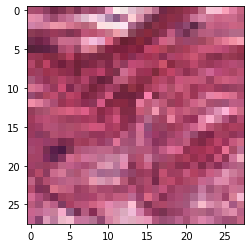

In [18]:
nd_array_x_train = tf.make_ndarray(x_train.op.get_attr("value"))
plt.imshow(nd_array_x_train[0])

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:2325: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


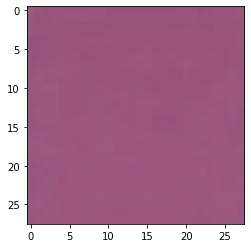

In [23]:
nd_array_x_train = np.reshape(nd_array_x_train, (5000, 28, 28, 3))
plt.imshow(vae.predict(nd_array_x_train)[0])

## Autoencoders

#### Standard Autoencoder class definition

In [11]:
class Autoencoder(Model):

  def __init__(self, input_img):

    super(Autoencoder, self).__init__()

    self.conv2d_1 = Conv2D(filters = 16, kernel_size = (3, 3), activation='relu', padding='same', input_shape = input_img)
    self.pool2d_1 = MaxPooling2D(pool_size = (2, 2), padding='same')

    self.conv2d_2 = Conv2D(filters = 8, kernel_size = (3, 3), activation='relu', padding='same')
    self.pool2d_2 = MaxPooling2D(pool_size = (2, 2), padding='same')

    self.conv2d_3 = Conv2D(filters = 8, kernel_size = (3, 3), activation='relu', padding='same')
    self.pool2d_3 = MaxPooling2D(pool_size = (2, 2), padding='same')

    self.flatten = Flatten()
    self.dense = Dense(4*4*8)

    self.reshape = Reshape((4,4,8))

    self.deconv2d_1 = Conv2D(8, (3, 3), activation='relu', padding='same')
    self.ups2d_1    = UpSampling2D((2, 2))

    self.deconv2d_2 = Conv2D(8, (3, 3), activation='relu', padding='same')
    self.ups2d_2    = UpSampling2D((2, 2))

    self.deconv2d_3 = Conv2D(16, (3, 3), activation='relu')
    self.ups2d_3    = UpSampling2D((2, 2))

    self.decode = Conv2D(3, (3, 3), activation='sigmoid', padding='same')

  def call(self, data, training = False):

    x = self.conv2d_1(data)
    x = self.pool2d_1(x)
    x = self.conv2d_2(x)
    x = self.pool2d_2(x)
    x = self.conv2d_3(x)
    x = self.pool2d_3(x)
    x = self.flatten(x)
    x = self.dense(x)
    x = self.reshape(x)
    x = self.deconv2d_1(x)
    x = self.ups2d_1(x)
    x = self.deconv2d_2(x)
    x = self.ups2d_2(x)
    x = self.deconv2d_3(x)
    x = self.ups2d_3(x)

    return self.decode(x)

#### Autoencoder with Perceptual Loss from VGG16 class definition

In [130]:
class PLAE(Model):

  def __init__(self, input_img):
    
    super(PLAE, self).__init__()

    self.loss_model = self.build_loss_model(input_img)

    # Autoencoder #

    self.conv2d_1 = Conv2D(filters = 16, kernel_size = (3, 3), activation='relu', padding='same', input_shape = input_img)
    self.pool2d_1 = MaxPooling2D(pool_size = (2, 2), padding='same')

    self.conv2d_2 = Conv2D(filters = 8, kernel_size = (3, 3), activation='relu', padding='same')
    self.pool2d_2 = MaxPooling2D(pool_size = (2, 2), padding='same')

    self.conv2d_3 = Conv2D(filters = 8, kernel_size = (3, 3), activation='relu', padding='same')
    self.pool2d_3 = MaxPooling2D(pool_size = (2, 2), padding='same')

    self.flatten = Flatten()
    self.dense = Dense(19*19*8)

    self.reshape = Reshape((19,19,8))

    self.deconv2d_1 = Conv2D(8, (3, 3), activation='relu', padding='same')
    self.ups2d_1    = UpSampling2D((2, 2))

    self.deconv2d_2 = Conv2D(8, (3, 3), activation='relu', padding='same')
    self.ups2d_2    = UpSampling2D((2, 2))

    self.deconv2d_3 = Conv2D(16, (3, 3), activation='relu')
    self.ups2d_3    = UpSampling2D((2, 2))

    self.decode = Conv2D(3, (3, 3), activation='sigmoid', padding='same')
    
  def call(self, data, training = False):

    x = self.conv2d_1(data)
    x = self.pool2d_1(x)
    x = self.conv2d_2(x)
    x = self.pool2d_2(x)
    x = self.conv2d_3(x)
    x = self.pool2d_3(x)
    x = self.flatten(x)
    x = self.dense(x)
    x = self.reshape(x)
    x = self.deconv2d_1(x)
    x = self.ups2d_1(x)
    x = self.deconv2d_2(x)
    x = self.ups2d_2(x)
    x = self.deconv2d_3(x)
    x = self.ups2d_3(x)

    return self.decode(x)

  def model(self, input_img):
    x = Input(shape=input_img)
    return Model(inputs=[x], outputs=self.call(x))

  def build_loss_model(self, input_img):
    loss_model = VGG16(include_top = False, weights = "imagenet", input_shape = input_img)

    loss_model.trainable = False

    for layer in loss_model.layers:
      layer.trainable = False

    return loss_model

  def plae_loss(self, batch):

    X = batch[0]
    y = batch[1]

    decoded_images = self.call(X)

    model_loss      = np.mean(keras.losses.MSE(y, decoded_images))
    perceptual_loss = self.get_perceptual_loss(y, decoded_images)

    return model_loss + 0.1 * perceptual_loss

  def get_perceptual_loss(self, y_true, y_pred):

    y_true = preprocess_input(y_true * 255)
    y_pred = preprocess_input(y_pred * 255)

    return K.mean(K.square(self.loss_model(y_true) - self.loss_model(y_pred)))

  def train_step(self, epoch, batch):
    
    with tf.GradientTape() as tape:
      
      tape.watch(self.trainable_variables)

      loss = self.plae_loss(batch)
      
      gradient = tape.gradient(loss, self.trainable_variables)
    
    self.optimizer.apply_gradients(zip(gradient, self.trainable_variables))

    return loss

  def train(self, data, epochs):

    # Iterate over epochs.
    for epoch in range(epochs):
        print("Start of epoch %d" % (epoch,))

        # Iterate over the batches of the dataset.
        for step, x_batch_train in enumerate(data):

          batch = tf.cast(x_batch_train, tf.dtypes.float32)

          loss = self.train_step(epoch, batch)

          if step % 100 == 0:
            if step == 0:
              print("step %d   - mean loss = %.4f" % (step, loss))
            else: 
              print("step %d - mean loss = %.4f" % (step, loss))
        
        print()

#### Beta-Variational Autoencoder class definition

In [158]:
class Sampling(keras.layers.Layer):

  def call(self, inputs):
    z_mean, z_log_var = inputs

    batch = tf.shape(z_mean)[0]
    dim   = tf.shape(z_mean)[1]

    epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
    return z_mean + tf.exp(0.5 * z_log_var) * epsilon

class CVAE(Model):

  def __init__(self, beta, input_shape, latent_dim):

    super(CVAE, self).__init__()

    self.beta = beta

    # Encoding #

    # Conv1 #
    self.conv2d_1 = Conv2D(filters = 16, kernel_size = (3, 3), activation='relu', padding='same', input_shape = input_shape)
    self.pool2d_1 = MaxPooling2D(pool_size = (2, 2), padding='same')
    self.enc_bn_1 = BatchNormalization()

    # Conv2 #
    self.conv2d_2 = Conv2D(filters = 8, kernel_size = (3, 3), activation='relu', padding='same')
    self.pool2d_2 = MaxPooling2D(pool_size = (2, 2), padding='same')
    self.enc_bn_2 = BatchNormalization()

    # Conv 3 #
    self.conv2d_3 = Conv2D(filters = 8, kernel_size = (3, 3), activation='relu', padding='same')
    self.pool2d_3 = MaxPooling2D(pool_size = (2, 2), padding='same')
    self.enc_bn_3 = BatchNormalization()

    conv_shape = (None, 4, 4, 8)

    # Latent space #
    self.flatten   = Flatten()
    self.enc_dense = Dense(conv_shape[1]*conv_shape[2]*conv_shape[3], activation = "relu")

    self.z_mu    = Dense(latent_dim)
    self.z_sigma = Dense(latent_dim)

    self.z = Sampling()

    # Decoding #

    self.dense    = Dense(conv_shape[1]*conv_shape[2]*conv_shape[3], activation="relu", input_shape = (latent_dim, ))
    self.reshape  = Reshape((conv_shape[1], conv_shape[2], conv_shape[3]))
    self.dec_bn_0 = BatchNormalization()

    # DeConv1
    self.deconv2d_1 = Conv2D(8, (3, 3), activation='relu', padding='same')
    self.ups2d_1    = UpSampling2D((2, 2))
    self.dec_bn_1   = BatchNormalization()

    # DeConv2 
    self.deconv2d_2 = Conv2D(8, (3, 3), activation='relu', padding='same')
    self.ups2d_2    = UpSampling2D((2, 2))
    self.dec_bn_2   = BatchNormalization()

    # DeConv3
    self.deconv2d_3 = Conv2D(16, (3, 3), activation='relu')
    self.ups2d_3    = UpSampling2D((2, 2))
    self.dec_bn_3   = BatchNormalization()

    self.decoded = Conv2D(3, (3, 3), activation='sigmoid', padding='same')

  def call(self, input_tensor, training = False):

    x = self.conv2d_1(input_tensor)
    x = self.pool2d_1(x)
    x = self.enc_bn_1(x)
    x = self.conv2d_2(x)
    x = self.pool2d_2(x)
    x = self.enc_bn_2(x)
    x = self.conv2d_3(x)
    x = self.pool2d_3(x)
    x = self.enc_bn_3(x)

    x     = self.flatten(x)
    dense = self.enc_dense(x)

    z_mu    = self.z_mu(dense)
    z_sigma = self.z_sigma(dense)

    z = self.z([z_mu, z_sigma])

    x = self.dense(z)
    x = self.reshape(x)
    x = self.dec_bn_0(x)
    x = self.deconv2d_1(x)
    x = self.ups2d_1(x)
    x = self.dec_bn_1(x)
    x = self.deconv2d_2(x)
    x = self.ups2d_2(x)
    x = self.dec_bn_2(x)
    x = self.deconv2d_3(x)
    x = self.ups2d_3(x)
    x = self.dec_bn_3(x)

    reconstructed = self.decoded(x)

    return z, z_mu, z_sigma, reconstructed

  def model(self, input_img):
    x = Input(shape=input_img)
    return Model(inputs=[x], outputs=self.call(x)[3])

  def loss(self, batch):

    X = batch[0]
    y = batch[1]

    z, z_mu, z_sigma, decoded_images = self.call(X)

    model_loss = np.mean(keras.losses.MSE(y, decoded_images))
    kl_loss    = -0.5 * K.mean(1 + z_sigma - tf.square(z_mu) - tf.exp(z_sigma))

    return model_loss + self.beta * kl_loss 

  def train_step(self, epoch, batch):
    
    with tf.GradientTape() as tape:
      
      tape.watch(self.trainable_variables)

      loss = self.loss(batch)
      
      gradient = tape.gradient(loss, self.trainable_variables)
    
    self.optimizer.apply_gradients(zip(gradient, self.trainable_variables))

    return loss

  def train(self, data, epochs):

    # Iterate over epochs.
    for epoch in range(epochs):
        print("Start of epoch %d" % (epoch,))

        # Iterate over the batches of the dataset.
        for step, x_batch_train in enumerate(data):

          batch = tf.cast(x_batch_train, tf.dtypes.float32)

          loss = self.train_step(epoch, batch)

          if step % 100 == 0:
            if step == 0:
              print("step %d   - mean loss = %.4f" % (step, loss))
            else: 
              print("step %d - mean loss = %.4f" % (step, loss))
        
        print()

  def train(self, data, epochs):
    optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)
    mse_loss_fn = tf.keras.losses.MeanSquaredError()

    loss_metric = tf.keras.metrics.Mean()

    # Iterate over epochs.
    for epoch in range(epochs):
        print("Start of epoch %d" % (epoch,))

        # Iterate over the batches of the dataset.
        for step, x_batch_train in enumerate(data):

          batch = tf.cast(x_batch_train, tf.dtypes.float32)[0]

          with tf.GradientTape() as tape:

            tape.watch(self.trainable_variables)
            _, _, _, reconstructed = self.call(batch)
            # Compute reconstruction loss
            loss = mse_loss_fn(batch, reconstructed)
            loss += sum(vae.losses)  # Add KLD regularization loss

          grads = tape.gradient(loss, self.trainable_variables)
          optimizer.apply_gradients(zip(grads, self.trainable_variables))

          loss_metric(loss)

          if step % 100 == 0:
            if step == 0:
              print("step %d   - mean loss = %.4f" % (step, loss_metric.result()))
            else: 
              print("step %d - mean loss = %.4f" % (step, loss_metric.result()))
        
        print()